# Applying supervised learning to predict student dropout

In this project, we will examine student data and use supervised learning techniques to predict whether a student will drop out. In the education sector, retaining students is vital for the institution's financial stability and for students’ academic success and personal development. A high dropout rate can lead to significant revenue loss, diminished institutional reputation, and lower overall student satisfaction.

We  work with the data in three distinct stages:

1.  Applicant and course information
2.  Student and engagement data
3.  Academic performance data

These stages reflect Study Group’s real-world data journey and how student information has progressed and become available. Additionally, this approach enables you, through data exploration, to support Study Group in better understanding and identifying key metrics to monitor. This approach will also assist you in determining at which stage of the student journey interventions would be most effective.


## Business context
Study Group specialises in providing educational services and resources to students and professionals across various fields. The company's primary focus is on enhancing learning experiences through a range of services, including online courses, tutoring, and educational consulting. By leveraging cutting-edge technology and a team of experienced educators, Study Group aims to bridge the gap between traditional learning methods and the evolving needs of today's learners.

Study Group serves its university partners by establishing strategic partnerships to enhance the universities’ global reach and diversity. It supports the universities in their efforts to attract international students, thereby enriching the cultural and academic landscape of their campuses. It works closely with university faculty and staff to ensure that the universities are prepared and equipped to welcome and support a growing international student body. Its partnership with universities also offers international students a seamless transition into their chosen academic environment.

Study Group runs several International Study Centres across the UK and Dublin in partnership with universities with the aim of preparing a pipeline of talented international students from diverse backgrounds for degree study. These centres help international students adapt to the academic, cultural, and social aspects of studying abroad. This is achieved by improving conversational and subject-specific language skills and academic readiness before students progress to a full degree programme at university.

Through its comprehensive suite of services, it supports learners and universities at every stage of their educational journey, from high school to postgraduate studies. Its approach is tailored to meet the unique needs of each learner, offering personalised learning paths and flexible scheduling options to accommodate various learning styles and commitments.

Study Group's services are designed to be accessible and affordable, making quality education a reality for many individuals. By focusing on the integration of technology and personalised learning, the company aims to empower learners to achieve their full potential and succeed in their academic and professional pursuits. Study Group is at the forefront of transforming how people learn and grow through its dedication to innovation and excellence.




# Stage 1 data

In [ ]:
# File URL
file_url = "https://drive.google.com/uc?id=1pA8DDYmQuaLyxADCOZe1QaSQwF16q1J6"

# Import modules

In [ ]:
pip install keras-tuner

In [ ]:
# Start coding from here with Stage 1 dataset
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, roc_auc_score,
                             ConfusionMatrixDisplay)
from sklearn.utils import class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import keras_tuner as kt


seed = 237


# Set seed

In [ ]:


seed = 237 # You can choose any integer

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(seed)

# 2. Set `python` built-in pseudo-random number generator at a fixed value
random.seed(seed)

# 3. Set `numpy` pseudo-random number generator at a fixed value
np.random.seed(seed)

# 4. Set `tensorflow` pseudo-random number generator at a fixed value
tf.random.set_seed(seed)

# If you're using older TensorFlow versions or have GPU-specific randomness issues
# tf.compat.v1.set_random_seed(seed_value)
# tf.config.experimental.set_synchronous_execution(True) # For GPU, may impact performance

print(f"All random seeds set to {seed} for reproducibility.")

All random seeds set to 237 for reproducibility.


##View Data

In [ ]:
stage_1_df = pd.read_csv(file_url)
display(stage_1_df.head())
print('\n\n')
display(stage_1_df.info())
print('\n')
print('Data shape:')
display(stage_1_df.shape)
print('\n')
stage_1_df.describe()
print('\n')
print('number of unique values:')
display(stage_1_df.nunique())
print('\n')
print('number of null values:')
display(stage_1_df.isnull().sum())


,CentreName,LearnerCode,BookingType,LeadSource,DiscountType,DateofBirth,Gender,Nationality,HomeState,HomeCity,CourseLevel,CourseName,IsFirstIntake,CompletedCourse,ProgressionDegree,ProgressionUniversity
0,ISC_Aberdeen,2284932,Agent,Standard Agent Booking,NaN,13/01/1998,Male,Chinese,Jianye District; Jiangsu Province,Nanjing,Pre-Masters,Business and Law Pre-Masters,True,Yes,Msc Econ Accounting and Investment Management,University of Aberdeen
1,ISC_Aberdeen,2399500,Agent,Standard Agent Booking,NaN,12/2/1998,Male,Chinese,NaN,Xi'an,Foundation,Life Sciences Undergraduate Foundation Programme,False,Yes,BSc Biological Sciences,University of Aberdeen
2,ISC_Aberdeen,2424946,Agent,Standard Agent Booking,NaN,7/4/2000,Male,Chinese,NaN,Chengdu,International Year Two,Business Management and Finance International ...,False,Yes,MA Finance,University of Aberdeen
3,ISC_Aberdeen,2426583,Agent,Standard Agent Booking,NaN,18/05/1999,Male,Chinese,NaN,LIUYANG CITY ;CHANGSHA,International Year Two,Business Management and Finance International ...,True,Yes,MA Business Management,University of Aberdeen
4,ISC_Aberdeen,2434674,Agent,Standard Agent Booking,NaN,19/04/1996,Male,Chinese,NaN,Xiamen,Pre-Masters,Business and Law Pre-Masters,True,Yes,MSc International Business Management,University of Aberdeen





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25059 entries, 0 to 25058
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   CentreName             25059 non-null  object
 1   LearnerCode            25059 non-null  int64 
 2   BookingType            25059 non-null  object
 3   LeadSource             25059 non-null  object
 4   DiscountType           7595 non-null   object
 5   DateofBirth            25059 non-null  object
 6   Gender                 25059 non-null  object
 7   Nationality            25059 non-null  object
 8   HomeState              8925 non-null   object
 9   HomeCity               21611 non-null  object
 10  CourseLevel            25059 non-null  object
 11  CourseName             25059 non-null  object
 12  IsFirstIntake          25059 non-null  bool  
 13  CompletedCourse        25059 non-null  object
 14  ProgressionDegree      24184 non-null  object
 15  ProgressionUnive

None



Data shape:


(25059, 16)





number of unique values:


,0
CentreName,19
LearnerCode,24877
BookingType,2
LeadSource,7
DiscountType,11
DateofBirth,4705
Gender,2
Nationality,151
HomeState,2448
HomeCity,5881




number of null values:


,0
CentreName,0
LearnerCode,0
BookingType,0
LeadSource,0
DiscountType,17464
DateofBirth,0
Gender,0
Nationality,0
HomeState,16134
HomeCity,3448


## Pre-process Data

In [ ]:
def pre_process_data(stage_1_df):
  learner_df = stage_1_df.copy()
  learner_df= learner_df.drop(columns=['LearnerCode'])

  # Convert 'DateofBirth' to datetime objects
  learner_df['DateofBirth'] = pd.to_datetime(learner_df['DateofBirth'], format='%d/%m/%Y')

  # Calculate age based on 31/10/2025
  reference_date = pd.to_datetime('31/10/2025', format='%d/%m/%Y')
  learner_df['Age'] = ((reference_date - learner_df['DateofBirth']).dt.days / 365).round().astype(int)

  non_numeric_columns = learner_df.select_dtypes(exclude=['number']).columns

  highCardinality=learner_df[non_numeric_columns].nunique()[learner_df[non_numeric_columns].nunique()>200].index
  learner_df=learner_df.drop(columns=highCardinality)

  halfNaN_columns=learner_df.columns[learner_df.isna().mean()>0.5]
  learner_df=learner_df.drop(columns=halfNaN_columns)

  learner_df.rename(columns={'CompletedCourse':'target'},inplace=True)
  return learner_df



In [ ]:
learner_df=pre_process_data(stage_1_df)

In [ ]:
learner_df.head()

,CentreName,BookingType,LeadSource,Gender,Nationality,CourseLevel,CourseName,IsFirstIntake,target,ProgressionUniversity,Age
0,ISC_Aberdeen,Agent,Standard Agent Booking,Male,Chinese,Pre-Masters,Business and Law Pre-Masters,True,Yes,University of Aberdeen,28
1,ISC_Aberdeen,Agent,Standard Agent Booking,Male,Chinese,Foundation,Life Sciences Undergraduate Foundation Programme,False,Yes,University of Aberdeen,28
2,ISC_Aberdeen,Agent,Standard Agent Booking,Male,Chinese,International Year Two,Business Management and Finance International ...,False,Yes,University of Aberdeen,26
3,ISC_Aberdeen,Agent,Standard Agent Booking,Male,Chinese,International Year Two,Business Management and Finance International ...,True,Yes,University of Aberdeen,26
4,ISC_Aberdeen,Agent,Standard Agent Booking,Male,Chinese,Pre-Masters,Business and Law Pre-Masters,True,Yes,University of Aberdeen,30


In [ ]:
learner_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25059 entries, 0 to 25058
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   CentreName             25059 non-null  object
 1   BookingType            25059 non-null  object
 2   LeadSource             25059 non-null  object
 3   Gender                 25059 non-null  object
 4   Nationality            25059 non-null  object
 5   CourseLevel            25059 non-null  object
 6   CourseName             25059 non-null  object
 7   IsFirstIntake          25059 non-null  bool  
 8   target                 25059 non-null  object
 9   ProgressionUniversity  25059 non-null  object
 10  Age                    25059 non-null  int64 
dtypes: bool(1), int64(1), object(9)
memory usage: 1.9+ MB


## Create Train and Test data, transform columns based on types

In [ ]:
def create_transform_train_test(learner_df):
  # Make a copy to avoid modifying the original dataframe
  processed_learner_df = learner_df.copy()

  # Map target after copying, but BEFORE splitting X and y
  target_map = {'Yes': 1, 'No': 0}
  processed_learner_df['target'] = processed_learner_df['target'].map(target_map)

  X = processed_learner_df.drop(columns=['target'])
  y = processed_learner_df['target']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

  ordinal_features = ['CourseLevel']
  course_level_order = [
        'Foundation',
        'International Year One',
        'International Year Two',
        'Pre-Masters'
    ]

  # Dynamically identify column types from X_train
  # Include both numeric and boolean dtypes for the numerical pipeline
  numerical_features = X_train.select_dtypes(include=[np.number, bool]).columns.tolist()
  all_object_columns = X_train.select_dtypes(include='object').columns.tolist()
  # categorical features are all object columns NOT in ordinal_features
  categorical_features = [col for col in all_object_columns if col not in ordinal_features]

  # 3. Create the Preprocessing Pipelines
  #    Pipeline for numerical data

  num_pipeline = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy='mean')),
      ('scaler', StandardScaler())
  ])

  #    Pipeline for nominal (one-hot) categorical data
  cat_pipeline = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy='most_frequent')),
      ('onehot', OneHotEncoder(handle_unknown='ignore'))
  ])

  #    Pipeline for ordinal data
  ord_pipeline = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy='most_frequent')),
      ('encoder', OrdinalEncoder(categories=[course_level_order], handle_unknown='use_encoded_value', unknown_value=-1))
  ])

  # 4. Create the ColumnTransformer with explicit column lists
  preprocessor = ColumnTransformer(
      transformers=[
          ('num', num_pipeline, numerical_features),
          ('cat', cat_pipeline, categorical_features),
          ('ord', ord_pipeline, ordinal_features)
      ],
      remainder='passthrough' # Keeps any other columns not explicitly listed
  )

  print("--- Fitting the preprocessor ---")
  preprocessor.fit(X_train)

  print("\n--- Transforming X_train ---")
  X_train_processed = preprocessor.transform(X_train)
  print(f"X_train_processed shape: {X_train_processed.shape}")

  print("\n--- Transforming X_test ---")
  X_test_processed = preprocessor.transform(X_test)
  print(f"X_test_processed shape: {X_test_processed.shape}")

  return X_train_processed, X_test_processed, y_train, y_test, preprocessor

In [ ]:
X_train, X_test, y_train, y_test, preprocessor = create_transform_train_test(learner_df)

--- Fitting the preprocessor ---

--- Transforming X_train ---
X_train_processed shape: (20047, 390)

--- Transforming X_test ---
X_test_processed shape: (5012, 390)


## Target Variable balance

,count
target,
Yes,21305
No,3754


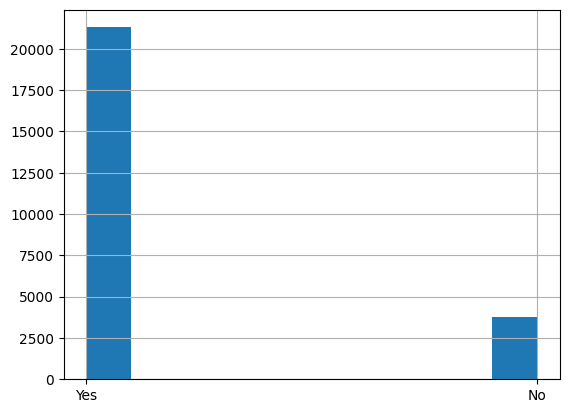

In [ ]:
learner_df['target'].hist()
learner_df['target'].value_counts()


 Target variable seems to be highly imbalanced, 21306 students completed the course, wherease 3754 dropped out. We will need to consider this when we are assessing accuracy metrics, or perhaps even for modelling

/tmp/ipython-input-2746746779.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Nationality', y='Count', data=nationality_counts_top50, palette='viridis')


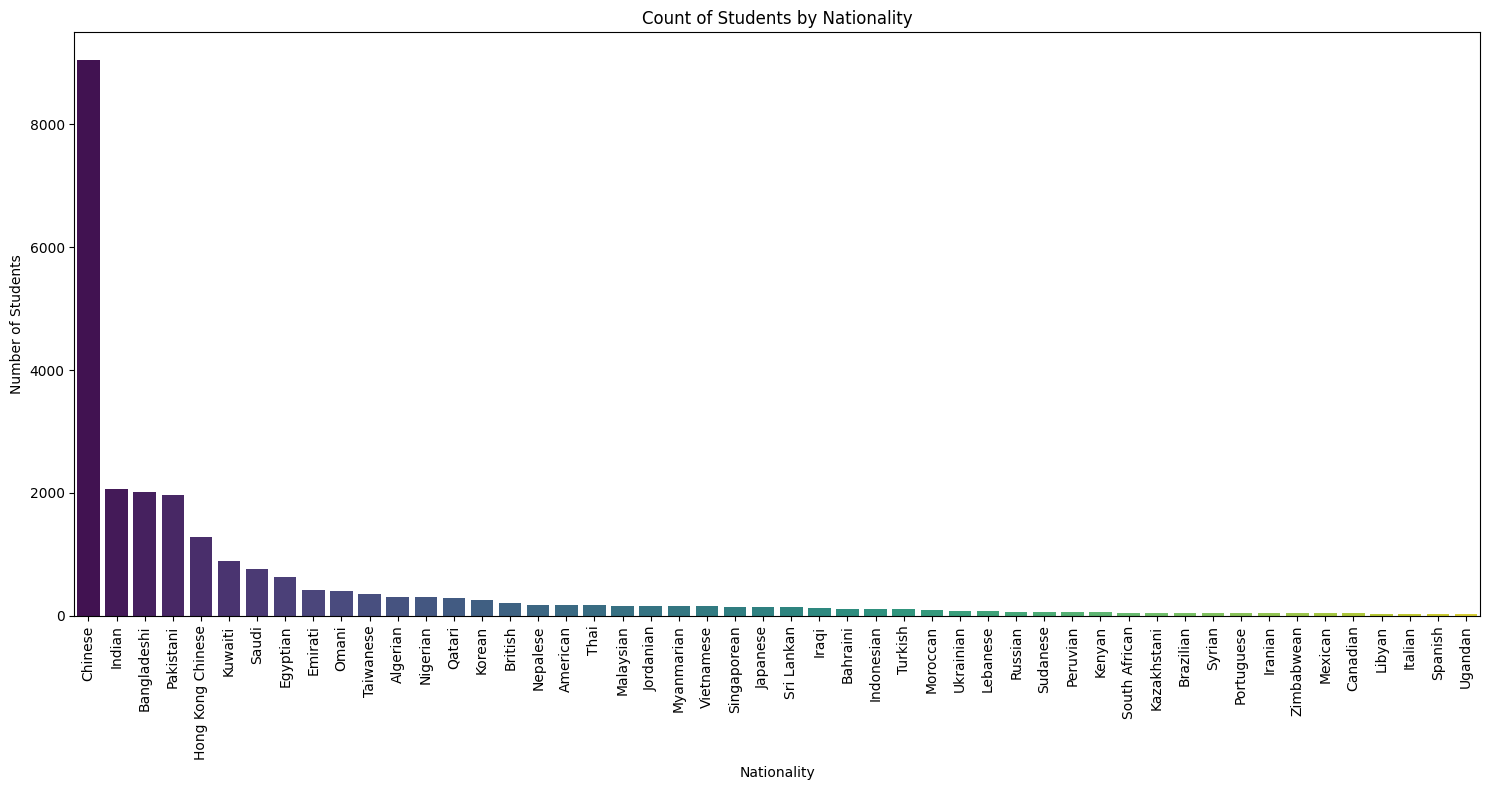

In [ ]:
# Calculate the count of each nationality
nationality_counts = learner_df['Nationality'].value_counts().reset_index()
nationality_counts.columns = ['Nationality', 'Count']

nationality_counts_top50=nationality_counts[:50]

# Create the bar chart
plt.figure(figsize=(15, 8))
sns.barplot(x='Nationality', y='Count', data=nationality_counts_top50, palette='viridis')
plt.title('Count of Students by Nationality')
plt.xlabel('Nationality')
plt.ylabel('Number of Students')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Initialize and train XGBoost

In [ ]:
def initialize_and_train_xgboost(X_train, y_train):
  ratio = (len(y_train) - sum(y_train)) / sum(y_train)

  model_xgb = xgb.XGBClassifier(random_state=seed)
  model_xgb.fit(X_train, y_train)

  model_xgb_balanced = xgb.XGBClassifier(random_state=seed, scale_pos_weight=ratio)
  model_xgb_balanced.fit(X_train, y_train)
  return model_xgb, model_xgb_balanced, ratio


In [ ]:
model_xgb, model_xgb_balanced,ratio = initialize_and_train_xgboost(X_train, y_train)

##Evaluate performance of baseline XGBoost model

In [ ]:
def evaluate_model(model, X_test, y_test):
  # For Keras models, .predict() typically returns probabilities if sigmoid is used
  # For sklearn/XGBoost classifiers, .predict() returns binary labels, and .predict_proba() returns probabilities

  # Get probabilities (works for both Keras and sklearn/XGBoost if .predict_proba exists)
  if hasattr(model, 'predict_proba'):
    model_probabilities = model.predict_proba(X_test)[:, 1]
  else: # Assume Keras model with sigmoid output, where .predict() gives probabilities
    model_probabilities = model.predict(X_test).flatten()

  # Convert probabilities to binary predictions using a 0.5 threshold
  y_pred = (model_probabilities > 0.5).astype(int)

  accuracy = accuracy_score(y_test, y_pred)
  classification_rep = classification_report(y_test, y_pred)
  confusion_mat = confusion_matrix(y_test, y_pred)
  roc_auc = roc_auc_score (y_test, model_probabilities) # Use probabilities for ROC AUC
  print(f"Accuracy: {accuracy}")
  print("Classification Report:\n", classification_rep)
  print("Confusion Matrix:\n", confusion_mat)
  print(f"ROC AUC Score: {roc_auc}")

  cfmd = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=["no","yes"])
  cfmd.plot()
  plt.show()

  return accuracy, classification_rep, confusion_mat, roc_auc

Accuracy: 0.8914604948124502
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.53      0.59       751
           1       0.92      0.96      0.94      4261

    accuracy                           0.89      5012
   macro avg       0.80      0.74      0.77      5012
weighted avg       0.88      0.89      0.89      5012

Confusion Matrix:
 [[ 398  353]
 [ 191 4070]]
ROC AUC Score: 0.8887010075902864


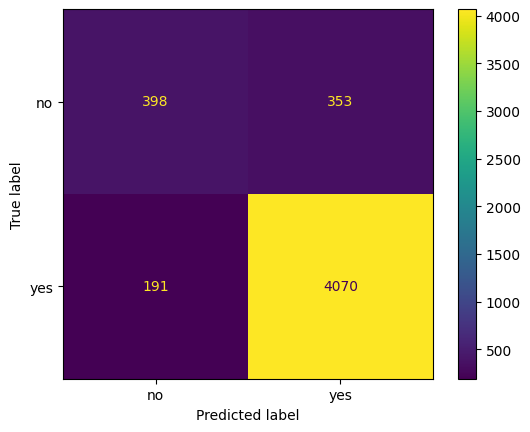

In [ ]:
performance_dict=[]
accuracy, classification_rep, confusion_mat, roc_auc=evaluate_model(model_xgb, X_test, y_test)
performance_dict.append({'model':'xgb_base', 'accuracy':accuracy, 'classification_rep':classification_rep, 'confusion_mat':confusion_mat, 'roc_auc':roc_auc})

Accuracy: 0.8539505187549881
Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.80      0.62       751
           1       0.96      0.86      0.91      4261

    accuracy                           0.85      5012
   macro avg       0.73      0.83      0.77      5012
weighted avg       0.89      0.85      0.87      5012

Confusion Matrix:
 [[ 602  149]
 [ 583 3678]]
ROC AUC Score: 0.8888216321756394


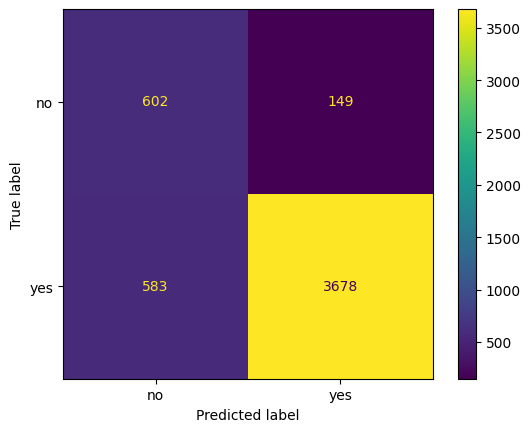

In [ ]:
accuracy, classification_rep, confusion_mat, roc_auc=evaluate_model(model_xgb_balanced, X_test, y_test)
performance_dict.append({'model':'xgb_base_balanced', 'accuracy':accuracy, 'classification_rep':classification_rep, 'confusion_mat':confusion_mat, 'roc_auc':roc_auc})

When we have scaled the positive observations down to balance the data (as the current distribution is imbalanced),  the Recall for negative class (drop-out) improved sharply. This is at the expense  of Precision of the "drop-out" class as well as the Recall for the "complete" class (however relatively small deterioration). So we capture more True drop outs however make more false drop-out predictions (i.e. miss more True completions). This is OK as it is more critical to predict the student  drop outs correctly than the completions in this task. The overall AUC score is useful here as the data is imbalanced. The balanced data has slightly better AUC score, however very minor difference. The Accuracy metric is not useful for comparison due to the imbalance.

We will continute to use the "balanced" scaled positive weight for tree methods going forward. for the XGBoost method going forwards for further hyper-parameter tuning.


## Hyperparameter tuning for XGBoost

In [ ]:
def hyperparameter_tuning_xgb(X_train, y_train, X_test, y_test):

  # Suppress a common warning
  warnings.filterwarnings("ignore", category=UserWarning)

  # 2. Instantiate the XGBoost classifier
  xgb_model = xgb.XGBClassifier(
      objective='binary:logistic',  # for binary classification
      eval_metric='auc',          # evaluation metric
      use_label_encoder=False,      # to avoid a deprecation warning
      scale_pos_weight=ratio,        # for handling class imbalance
      random_state=seed               # for reproducibility
  )

  # 3. Define the "grid" of parameters to search
  param_grid = {
      'learning_rate': [0.05, 0.1, 0.3],
      'max_depth': [2, 4, 6],
      'min_child_weight': [1, 3, 5],
      'n_estimators': [50, 100, 200],
  }

  # 4. Set up the GridSearchCV object
  # cv=5 means 5-fold cross-validation
  # n_jobs=-1 means use all available CPU cores
  # verbose=2 will print updates as it works
  grid_search = GridSearchCV(
      estimator=xgb_model,
      param_grid=param_grid,
      scoring='roc_auc',  # A good metric for binary classification
      cv=5,
      n_jobs=-1,
      verbose=2
  )

  # 5. Run the grid search
  print("Starting Grid Search...")
  grid_search.fit(X_train, y_train)

  # 6. Print the best results
  print("\n--- Grid Search Complete ---")
  print(f"Best parameters found: {grid_search.best_params_}")
  print(f"Best ROC AUC score: {grid_search.best_score_:.4f}")
  return grid_search

In [ ]:
grid_search = hyperparameter_tuning_xgb(X_train, y_train, X_test, y_test)

Starting Grid Search...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

--- Grid Search Complete ---
Best parameters found: {'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 200}
Best ROC AUC score: 0.8798



As a result of Grid Search:
Best parameters found: {'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200}
Best ROC AUC score on validation data: 0.8804

##Evaluate best XGBoost model

Accuracy: 0.8563447725458898
Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.80      0.63       751
           1       0.96      0.87      0.91      4261

    accuracy                           0.86      5012
   macro avg       0.74      0.83      0.77      5012
weighted avg       0.89      0.86      0.87      5012

Confusion Matrix:
 [[ 603  148]
 [ 572 3689]]
ROC AUC Score: 0.8917511533554104


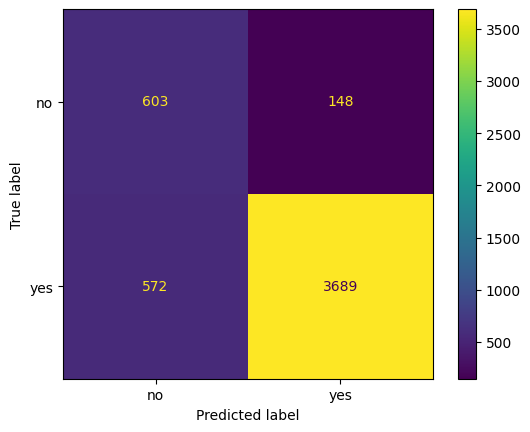

In [ ]:
accuracy, classification_rep, confusion_mat, roc_auc=evaluate_model(grid_search.best_estimator_, X_test, y_test)
performance_dict.append({'model':'xgb_best', 'accuracy':accuracy, 'classification_rep':classification_rep, 'confusion_mat':confusion_mat, 'roc_auc':roc_auc})

Best XGBoost model" following hyper-tuining seems to have slightly better AUC score compared to the base XGBoost model, as well as the F1 score for both classes. The improvement is small though.

## Feature Importances

In [ ]:
def get_feature_importances(model, preprocessor):
  feature_names = preprocessor.get_feature_names_out() # Get feature names from the preprocessor
  feature_importance = pd.Series(model.feature_importances_, index=feature_names).sort_values()
  feature_importance.iloc[-20:].plot.barh()
  plt.show()

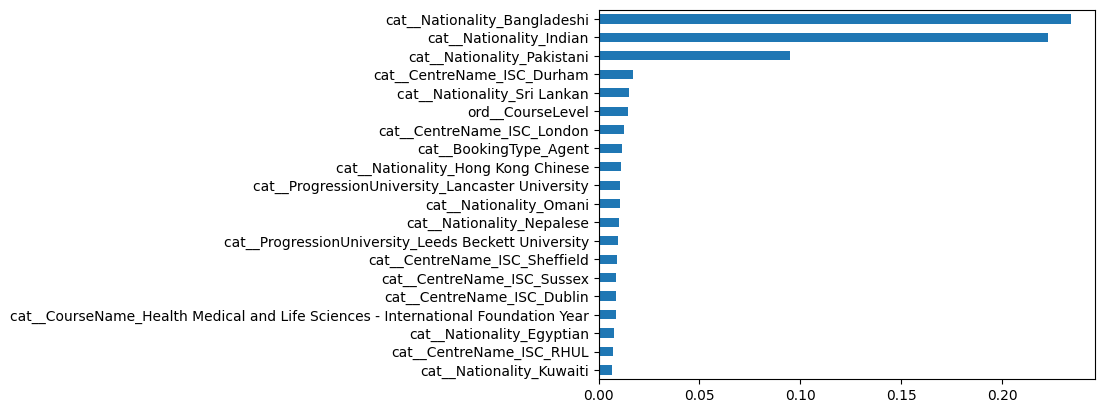

In [ ]:
get_feature_importances(grid_search.best_estimator_, preprocessor)

Nationality of the students seem to have largest importance for predicting student drop-out. For the actual direction and magnitude of impact, one can do a SHAP analysis.

## Create and Train Neural Network into Stage 1 data

In [ ]:
def create_and_train_nn(X_train, y_train):
  def create_model(learning_rate=0.001, l2_reg=0.001, numberofNeurons=64, depth=2, optimizer='Adam'):
      model = Sequential()
      model.add(Input(shape=(X_train.shape[1],)))
      #model.add(Dropout(rate=0.2))
      for _ in range(depth):
          model.add(Dense(units=numberofNeurons, activation='relu', kernel_regularizer=l2(l2_reg)))
          model.add(Dropout(rate=0.2))
      model.add(Dense(units=1, activation='sigmoid'))
      if optimizer == 'Adam':
          optimizer = Adam(learning_rate=learning_rate)
      elif optimizer == 'RMSprop':
          optimizer = RMSprop(learning_rate=learning_rate)
      model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'auc'])
      return model
  model_NN=create_model()
  call_back=EarlyStopping(monitor='val_auc',mode='max',patience=10,restore_best_weights=True)

  # Calculate weights based on your training labels (y_train)
  weights_array = class_weight.compute_class_weight(
      'balanced',
      classes=np.unique(y_train),
      y=y_train
  )
  # Convert to the dictionary format Keras needs
  class_weight_dict = dict(enumerate(weights_array))
  print(f"Using class weights: {class_weight_dict}")

  history_model = model_NN.fit(X_train, y_train,  validation_split=0.2, epochs=100, batch_size=32, callbacks=call_back, class_weight=class_weight_dict)
  return model_NN, history_model

In [ ]:
model_NN, history_model=create_and_train_nn(X_train, y_train)

Using class weights: {0: np.float64(3.337828837828838), 1: np.float64(0.5880955174841587)}
Epoch 1/100
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8051 - auc: 0.8036 - loss: 0.6375 - val_accuracy: 0.8372 - val_auc: 0.8774 - val_loss: 0.5007
Epoch 2/100
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8445 - auc: 0.8694 - loss: 0.4897 - val_accuracy: 0.8449 - val_auc: 0.8809 - val_loss: 0.4805
Epoch 3/100
502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8490 - auc: 0.8752 - loss: 0.4724 - val_accuracy: 0.8504 - val_auc: 0.8827 - val_loss: 0.4618
Epoch 4/100
502/502 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8487 - auc: 0.8755 - loss: 0.4666 - val_accuracy: 0.8496 - val_auc: 0.8828 - val_loss: 0.4590
Epoch 5/100
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8498 - auc: 0.8779 - loss: 0.4591 - val_accuracy: 0.8479 - val_auc: 0.8823 - val_loss: 0.4561
Epoch 6/100
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8517 - auc: 0.8789 - loss: 0.4573 - 

## Evaluate base NN model performance

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy: 0.8413806863527534
Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.81      0.60       751
           1       0.96      0.85      0.90      4261

    accuracy                           0.84      5012
   macro avg       0.72      0.83      0.75      5012
weighted avg       0.89      0.84      0.86      5012

Confusion Matrix:
 [[ 605  146]
 [ 649 3612]]
ROC AUC Score: 0.889592254526625


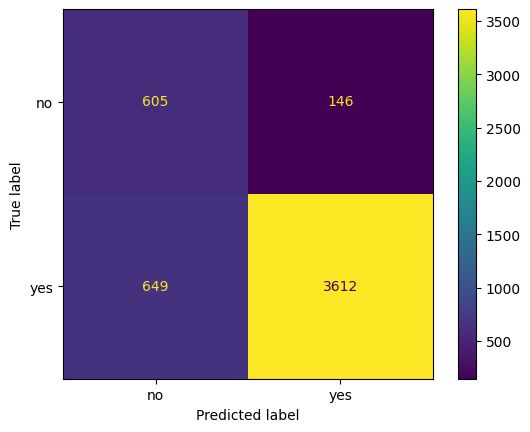

In [ ]:
accuracy, classification_rep, confusion_mat, roc_auc=evaluate_model(model_NN, X_test, y_test)
performance_dict.append({'model':'NN_base', 'accuracy':accuracy, 'classification_rep':classification_rep, 'confusion_mat':confusion_mat, 'roc_auc':roc_auc})

The baseline NN performance slightly better than XGBoost baseline, both in terms of AUC scoresm, however slightly lower F1.however really minor differences. Note we also treated the imbalanced dataset for hte NN to improve recall for class 0.

## Generate & Plot training and validation loss and accuracy history for NN

In [ ]:
def generate_and_plot_loss_accuracy_history(history_model):
  # Calculate the best epoch
  best_val_auc = np.max(history_model.history['val_auc'])
  best_epoch = np.argmax(history_model.history['val_auc']) + 1

  print(f"Training stopped at epoch {len(history_model.history['auc'])}")
  print(f"The best model weights were restored from epoch {best_epoch} with validation auc: {best_val_auc:.4f}")

  plt.figure(figsize=(12, 6))
  #plt.subplot(1, 3, 1)
  plt.plot(history_model.history['loss'], label='Training Loss')
  plt.plot(history_model.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.title('Training and Validation Loss')
  plt.show()

  #plt.subplot(1, 3, 2)
  plt.plot(history_model.history['accuracy'], label='Training Accuracy')
  plt.plot(history_model.history['val_accuracy'], label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.title('Training and Validation Accuracy')
  plt.show()

  #plt.subplot(1, 3, 3)
  plt.plot(history_model.history['auc'], label='Training AUC')
  plt.plot(history_model.history['val_auc'], label='Validation AUC')
  plt.xlabel('Epochs')
  plt.ylabel('AUC')
  plt.legend()
  plt.title('Training and Validation AUC')
  plt.show()

Training stopped at epoch 23
The best model weights were restored from epoch 13 with validation auc: 0.8839


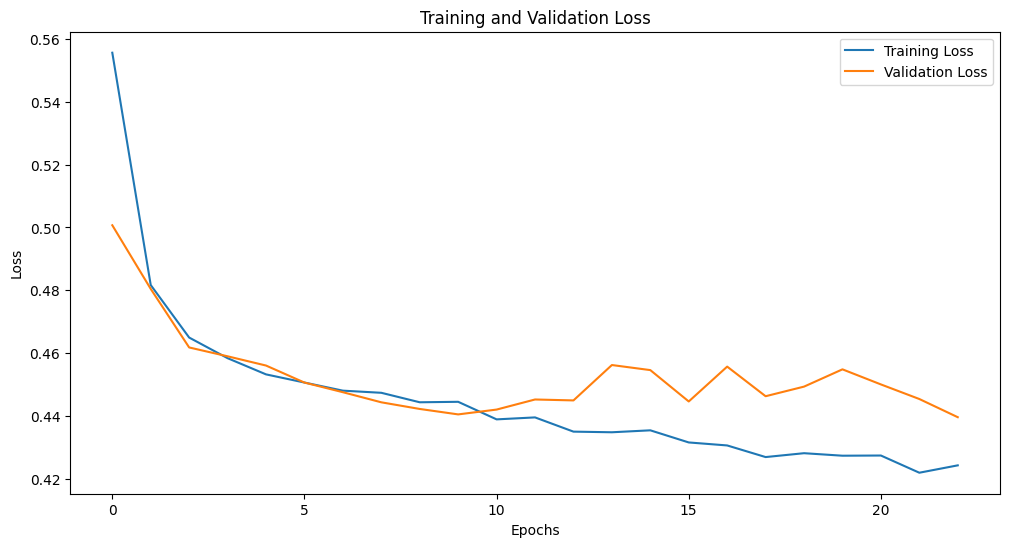

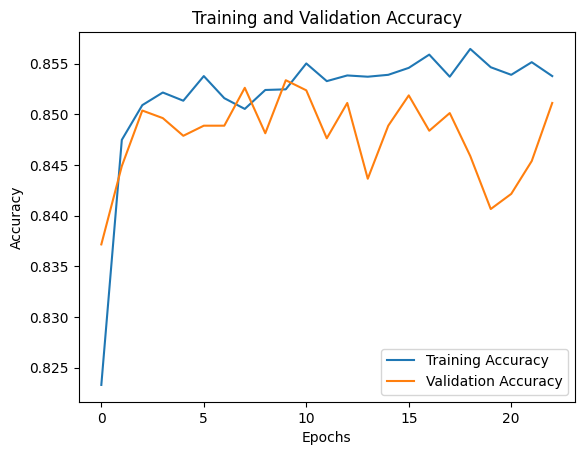

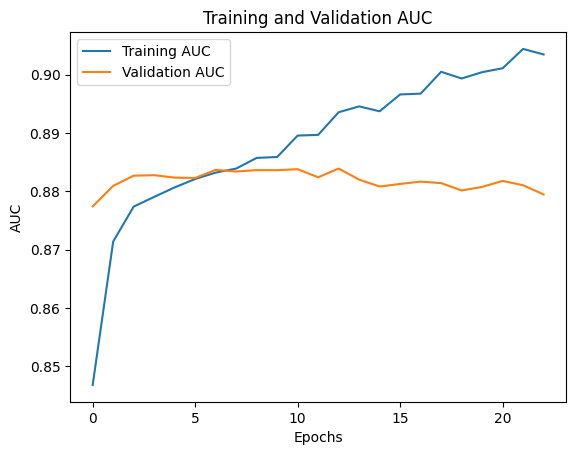

In [ ]:
generate_and_plot_loss_accuracy_history(history_model)

## Hyperparameter Tuning - Hyperband

In [ ]:
def get_best_hyperparameters_model_hyperband (X_train, y_train, project_name='StudentDropout'):

  def build_hypermodel(hp):

      model = Sequential()
      model.add(Input(shape=(X_train.shape[1],)))

      # --- Hyperparameter 1: Tune the depth (number of layers) ---
      hp_depth = hp.Int('depth', min_value=1, max_value=3, step=1)

      for i in range(hp_depth):
          # --- Hyperparameter 2: Tune the number of neurons -> it will try tapered layers as well
          hp_neurons = hp.Choice(f'neurons_layer_{i}', values=[32, 64, 128])
          model.add(Dense(units=hp_neurons, activation='relu'))
          model.add(Dropout(rate=0.2))

      model.add(Dense(units=1, activation='sigmoid'))

      # --- Hyperparameter 3: Tune the learning rate ---
      hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

      # --- Hyperparameter 4: Tune the optimizer ---
      hp_optimizer = hp.Choice('optimizer', values=['Adam', 'RMSprop'])

      if hp_optimizer == 'Adam':
          optimizer = Adam(learning_rate=hp_learning_rate)
      else:
          optimizer = RMSprop(learning_rate=hp_learning_rate)

      model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'auc'])

      return model

  # The Hyperband Tuner
  tuner_hyperband = kt.Hyperband(
      build_hypermodel,
      objective=kt.Objective('val_auc', direction='max'),
      max_epochs=50,   # <-- The MAX epochs a winning model will train for
      factor=3,        # <-- The reduction factor
      # executions_per_trial=3 # repeat calculation with 3 different seeds, somewhat like a cross validation fold
      project_name=project_name
  )

  # Calculate weights based on your training labels (y_train)
  weights_array = class_weight.compute_class_weight(
      'balanced',
      classes=np.unique(y_train),
      y=y_train
  )
  # Convert to the dictionary format Keras needs
  class_weight_dict = dict(enumerate(weights_array))
  print(f"Using class weights: {class_weight_dict}")

  # Create a validation split from your training data
  # The tuner needs this to score the models
  tuner_hyperband.search(X_train, y_train, epochs=50, validation_split=0.2, class_weight=class_weight_dict)

  # Get the best set of hyperparameters
  best_hps = tuner_hyperband.get_best_hyperparameters(num_trials=1)[0]

  # 1. Get the best depth first
  best_depth = best_hps.get('depth')

  # 2. Loop using that depth to get the neuron values
  neuron_layers = []
  for i in range(best_depth):
      neuron_layers.append(best_hps.get(f'neurons_layer_{i}'))

  # 3. Print the new, correct information
  print(f"""
  The best hyperparameters are:
  - Depth: {best_depth}
  - Neuron Layers: {neuron_layers}  # This will print something like [128, 64]
  - Optimizer: {best_hps.get('optimizer')}
  """)

  # Get the best model
  best_model = tuner_hyperband.get_best_models(num_models=1)[0]
  return best_model

In [ ]:
best_model=get_best_hyperparameters_model_hyperband(X_train, y_train, project_name='StudentDropout_Stage1')

Reloading Tuner from ./StudentDropout_Stage1/tuner0.json
Using class weights: {0: np.float64(3.337828837828838), 1: np.float64(0.5880955174841587)}

  The best hyperparameters are:
  - Depth: 2
  - Neuron Layers: [128, 128]  # This will print something like [128, 64]
  - Optimizer: RMSprop
  


## Evaluate best NN

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.8643256185155627
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.78      0.63       751
           1       0.96      0.88      0.92      4261

    accuracy                           0.86      5012
   macro avg       0.75      0.83      0.77      5012
weighted avg       0.89      0.86      0.87      5012

Confusion Matrix:
 [[ 586  165]
 [ 515 3746]]
ROC AUC Score: 0.8865994523143826


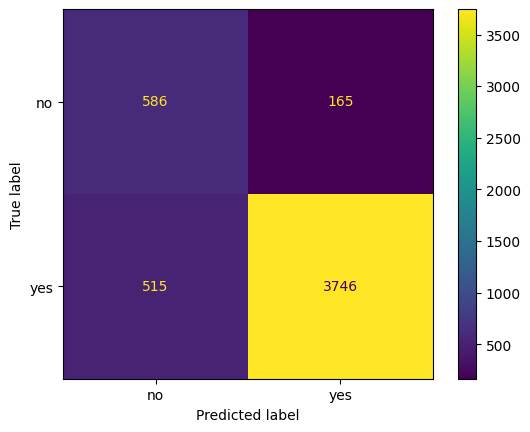

In [ ]:
accuracy, classification_rep, confusion_mat, roc_auc=evaluate_model(best_model, X_test, y_test)
performance_dict.append({'model':'NN_best', 'accuracy':accuracy, 'classification_rep':classification_rep, 'confusion_mat':confusion_mat, 'roc_auc':roc_auc})

The hyper-parameter tuned NN did not seem to perform better than the base model.
THis may be due to:
-  a "slow starter model" that was not picked by hyperband tuner
-  the optimal parameters on the grid were not picked by hyperband tuner. It does not try the entire grid, but randmly picks samples for speed.
etc.

# Stage 2 data

In [ ]:
# File URL
file_url = "https://drive.google.com/uc?id=1vy1JFQZva3lhMJQV69C43AB1NTM4W-DZ"


**Stage 2: Pre-processing instructions**

- Remove any columns not useful in the analysis (LearnerCode).
- Remove columns with high cardinality (use >200 unique values, as a guideline for this data set).
- Remove columns with >50% data missing.
- Perform ordinal encoding for ordinal data.
- Perform one-hot encoding for all other categorical data.
- Choose how to engage with missing values, which can be done in one of two ways for this project:
  *   Impute the rows with appropriate values.
  *   Remove rows with missing values but ONLY in cases where rows with missing values are minimal: <2% of the overall data.



## Data prep

In [ ]:
stage_2_df = pd.read_csv(file_url)
display(stage_2_df.head())
print('\n\n')
display(stage_2_df.info())
print('\n')
print('Data shape:')
display(stage_2_df.shape)
print('\n')
stage_2_df.describe()
print('\n')
print('number of unique values:')
display(stage_2_df.nunique())
print('\n')
print('number of null values:')
display(stage_2_df.isnull().sum())

,CentreName,LearnerCode,BookingType,LeadSource,DiscountType,DateofBirth,Gender,Nationality,HomeState,HomeCity,CourseLevel,CourseName,IsFirstIntake,CompletedCourse,ProgressionDegree,ProgressionUniversity,AuthorisedAbsenceCount,UnauthorisedAbsenceCount
0,ISC_Aberdeen,2284932,Agent,Standard Agent Booking,NaN,13/01/1998,Male,Chinese,Jianye District; Jiangsu Province,Nanjing,Pre-Masters,Business and Law Pre-Masters,True,Yes,Msc Econ Accounting and Investment Management,University of Aberdeen,NaN,NaN
1,ISC_Aberdeen,2399500,Agent,Standard Agent Booking,NaN,12/2/1998,Male,Chinese,NaN,Xi'an,Foundation,Life Sciences Undergraduate Foundation Programme,False,Yes,BSc Biological Sciences,University of Aberdeen,93.0,5.0
2,ISC_Aberdeen,2424946,Agent,Standard Agent Booking,NaN,7/4/2000,Male,Chinese,NaN,Chengdu,International Year Two,Business Management and Finance International ...,False,Yes,MA Finance,University of Aberdeen,92.0,6.0
3,ISC_Aberdeen,2426583,Agent,Standard Agent Booking,NaN,18/05/1999,Male,Chinese,NaN,LIUYANG CITY ;CHANGSHA,International Year Two,Business Management and Finance International ...,True,Yes,MA Business Management,University of Aberdeen,67.0,15.0
4,ISC_Aberdeen,2434674,Agent,Standard Agent Booking,NaN,19/04/1996,Male,Chinese,NaN,Xiamen,Pre-Masters,Business and Law Pre-Masters,True,Yes,MSc International Business Management,University of Aberdeen,NaN,NaN





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25059 entries, 0 to 25058
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CentreName                25059 non-null  object 
 1   LearnerCode               25059 non-null  int64  
 2   BookingType               25059 non-null  object 
 3   LeadSource                25059 non-null  object 
 4   DiscountType              7595 non-null   object 
 5   DateofBirth               25059 non-null  object 
 6   Gender                    25059 non-null  object 
 7   Nationality               25059 non-null  object 
 8   HomeState                 8925 non-null   object 
 9   HomeCity                  21611 non-null  object 
 10  CourseLevel               25059 non-null  object 
 11  CourseName                25059 non-null  object 
 12  IsFirstIntake             25059 non-null  bool   
 13  CompletedCourse           25059 non-null  object 
 14  Pro

None



Data shape:


(25059, 18)





number of unique values:


,0
CentreName,19
LearnerCode,24877
BookingType,2
LeadSource,7
DiscountType,11
DateofBirth,4705
Gender,2
Nationality,151
HomeState,2448
HomeCity,5881




number of null values:


,0
CentreName,0
LearnerCode,0
BookingType,0
LeadSource,0
DiscountType,17464
DateofBirth,0
Gender,0
Nationality,0
HomeState,16134
HomeCity,3448


##Pre-process data

In [ ]:
learner_df_2=pre_process_data(stage_2_df)

In [ ]:
learner_df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25059 entries, 0 to 25058
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CentreName                25059 non-null  object 
 1   BookingType               25059 non-null  object 
 2   LeadSource                25059 non-null  object 
 3   Gender                    25059 non-null  object 
 4   Nationality               25059 non-null  object 
 5   CourseLevel               25059 non-null  object 
 6   CourseName                25059 non-null  object 
 7   IsFirstIntake             25059 non-null  bool   
 8   target                    25059 non-null  object 
 9   ProgressionUniversity     25059 non-null  object 
 10  AuthorisedAbsenceCount    24851 non-null  float64
 11  UnauthorisedAbsenceCount  24851 non-null  float64
 12  Age                       25059 non-null  int64  
dtypes: bool(1), float64(2), int64(1), object(9)
memory usage: 2.3

##Create transformed Train & Test data

In [ ]:
X_train_2, X_test_2, y_train_2, y_test_2,preprocessor_2 = create_transform_train_test(learner_df_2) # create data for Tree method

--- Fitting the preprocessor ---

--- Transforming X_train ---
X_train_processed shape: (20047, 392)

--- Transforming X_test ---
X_test_processed shape: (5012, 392)


##Initialize and train base XGBoost

In [ ]:
model_xgb_2, model_xgb_balanced_2, ratio_2 = initialize_and_train_xgboost(X_train_2, y_train_2)

##Evaluate base  XGBoost model

Accuracy: 0.87609736632083
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.83      0.67       751
           1       0.97      0.88      0.92      4261

    accuracy                           0.88      5012
   macro avg       0.76      0.86      0.80      5012
weighted avg       0.91      0.88      0.89      5012

Confusion Matrix:
 [[ 626  125]
 [ 496 3765]]
ROC AUC Score: 0.9263699406033291


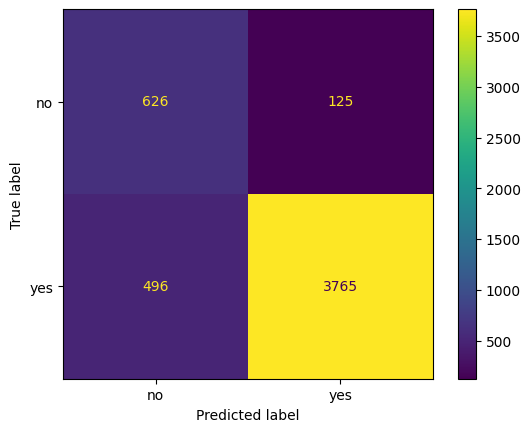

In [ ]:
accuracy, classification_rep, confusion_mat, roc_auc=evaluate_model(model_xgb_balanced_2, X_test_2, y_test_2)
performance_dict.append({'model':'xgb_base_2', 'accuracy':accuracy, 'classification_rep':classification_rep, 'confusion_mat':confusion_mat, 'roc_auc':roc_auc})

The base XGBoost model performance is somewhat significantly better, suggesting the new Absence related variables are important predictors for student drop out.

##Tune Hyper-parameters for XGBoost

In [ ]:
grid_search_2 = hyperparameter_tuning_xgb(X_train_2, y_train_2, X_test_2, y_test_2)

Starting Grid Search...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

--- Grid Search Complete ---
Best parameters found: {'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200}
Best ROC AUC score: 0.9138


## Evaluate tuned XGBoost

Accuracy: 0.8749002394253791
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.85      0.67       751
           1       0.97      0.88      0.92      4261

    accuracy                           0.87      5012
   macro avg       0.76      0.86      0.80      5012
weighted avg       0.91      0.87      0.88      5012

Confusion Matrix:
 [[ 636  115]
 [ 512 3749]]
ROC AUC Score: 0.9266983769743292


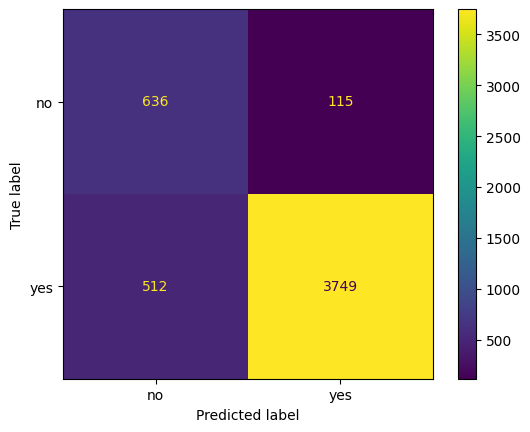

In [ ]:
accuracy, classification_rep, confusion_mat, roc_auc=evaluate_model(grid_search_2.best_estimator_, X_test_2, y_test_2)
performance_dict.append({'model':'xgb_best_2', 'accuracy':accuracy, 'classification_rep':classification_rep, 'confusion_mat':confusion_mat, 'roc_auc':roc_auc})

##Feature importances

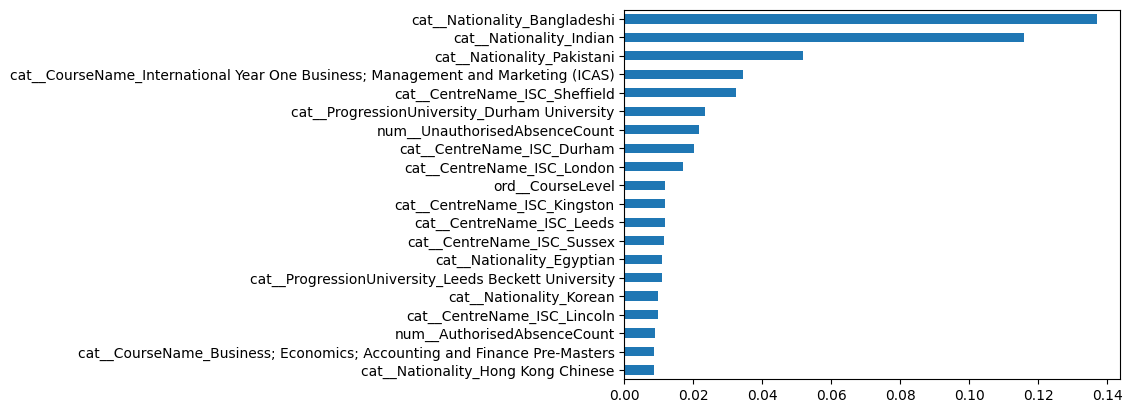

In [ ]:
get_feature_importances(grid_search_2.best_estimator_, preprocessor_2)

##Initialize and train base NN

In [ ]:
model_NN_2, history_model_2 = create_and_train_nn(X_train_2, y_train_2)

Using class weights: {0: np.float64(3.337828837828838), 1: np.float64(0.5880955174841587)}
Epoch 1/100
502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8100 - auc: 0.8305 - loss: 0.6104 - val_accuracy: 0.8312 - val_auc: 0.9030 - val_loss: 0.4707
Epoch 2/100
502/502 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8477 - auc: 0.8929 - loss: 0.4599 - val_accuracy: 0.8327 - val_auc: 0.9061 - val_loss: 0.4499
Epoch 3/100
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8490 - auc: 0.8966 - loss: 0.4416 - val_accuracy: 0.8329 - val_auc: 0.9078 - val_loss: 0.4414
Epoch 4/100
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8521 - auc: 0.8996 - loss: 0.4312 - val_accuracy: 0.8434 - val_auc: 0.9089 - val_loss: 0.4142
Epoch 5/100
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8544 - auc: 0.9014 - loss: 0.4241 - val_accuracy: 0.8444 - val_auc: 0.9088 - val_loss: 0.4108
Epoch 6/100
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8538 - auc: 0.8999 - loss: 0.4238 - v

## Evaluate base NN

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.8465682362330407
Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.86      0.63       751
           1       0.97      0.84      0.90      4261

    accuracy                           0.85      5012
   macro avg       0.73      0.85      0.76      5012
weighted avg       0.90      0.85      0.86      5012

Confusion Matrix:
 [[ 645  106]
 [ 663 3598]]
ROC AUC Score: 0.9130468614014138


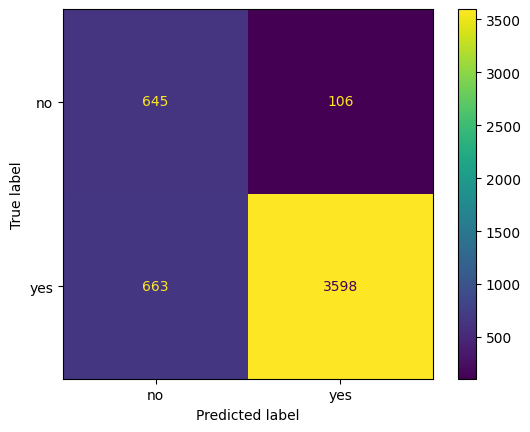

In [ ]:
accuracy, classification_rep, confusion_mat, roc_auc=evaluate_model(model_NN_2, X_test_2, y_test_2)
performance_dict.append({'model':'NN_base_2', 'accuracy':accuracy, 'classification_rep':classification_rep, 'confusion_mat':confusion_mat, 'roc_auc':roc_auc})

## Generate and Plot training & validation history NN

Training stopped at epoch 19
The best model weights were restored from epoch 9 with validation auc: 0.9111


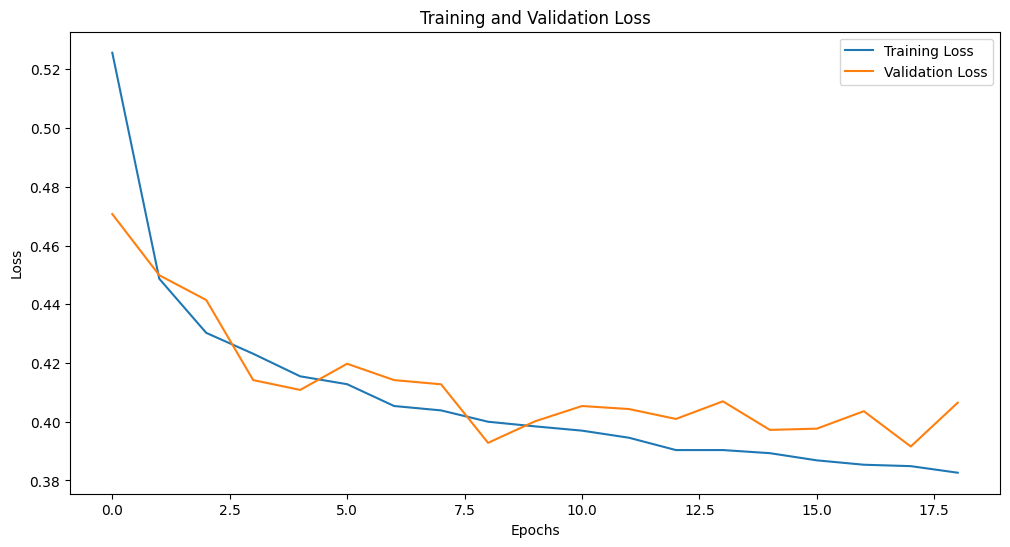

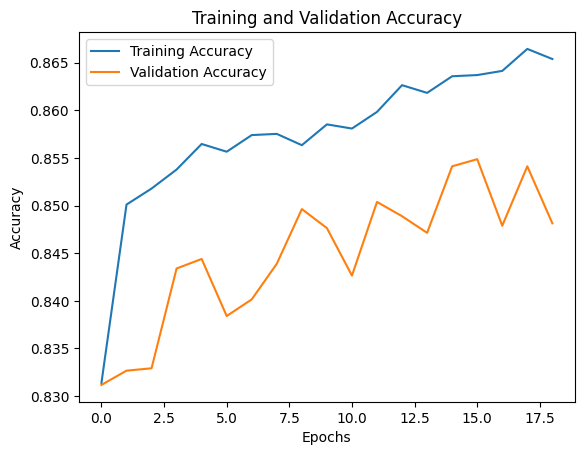

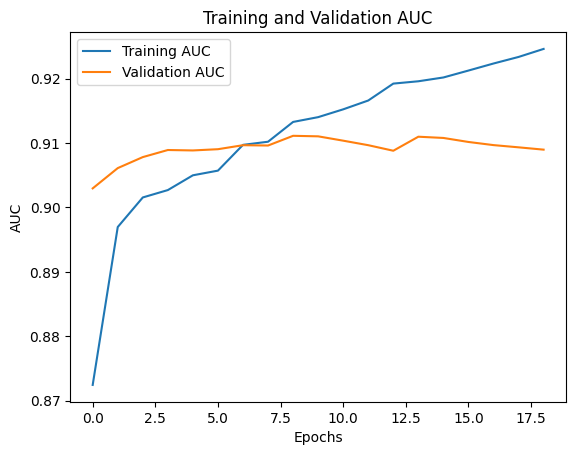

In [ ]:
generate_and_plot_loss_accuracy_history(history_model_2)

##Tune Hyper-parametes for NN (hyperband)

In [ ]:
best_model_2=get_best_hyperparameters_model_hyperband(X_train_2, y_train_2, project_name='StudentDropout_Stage2')

Trial 90 Complete [00h 01m 35s]
val_auc: 0.9083732962608337

Best val_auc So Far: 0.9104692935943604
Total elapsed time: 00h 47m 16s

  The best hyperparameters are:
  - Depth: 2
  - Neuron Layers: [128, 128]  # This will print something like [128, 64]
  - Optimizer: RMSprop
  


## Evaluate best NN

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy: 0.8661213088587391
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.82      0.65       751
           1       0.96      0.87      0.92      4261

    accuracy                           0.87      5012
   macro avg       0.75      0.85      0.78      5012
weighted avg       0.90      0.87      0.88      5012

Confusion Matrix:
 [[ 613  138]
 [ 533 3728]]
ROC AUC Score: 0.9110265558462143


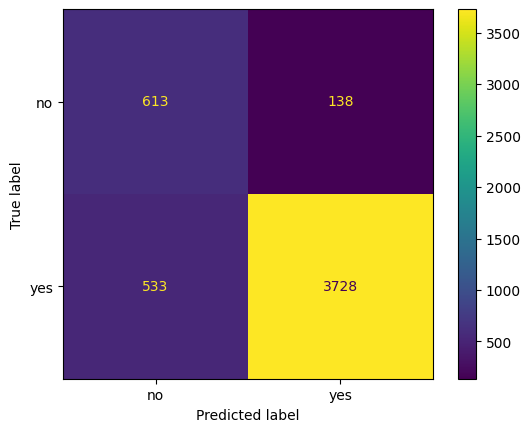

In [ ]:
accuracy, classification_rep, confusion_mat, roc_auc=evaluate_model(best_model_2, X_test_2, y_test_2)
performance_dict.append({'model':'NN_best_2', 'accuracy':accuracy, 'classification_rep':classification_rep, 'confusion_mat':confusion_mat, 'roc_auc':roc_auc})

# Stage 3 data

In [ ]:
# File URL
file_url = "https://drive.google.com/uc?id=18oyu-RQotQN6jaibsLBoPdqQJbj_cV2-"

**Stage 3: Pre-processing instructions**

- Remove any columns not useful in the analysis (LearnerCode).
- Remove columns with high cardinality (use >200 unique values, as a guideline for this data set).
- Remove columns with >50% data missing.
- Perform ordinal encoding for ordinal data.
- Perform one-hot encoding for all other categorical data.
- Choose how to engage with rows that have missing values, which can be done in one of two ways for this project:
  *   Impute the rows with appropriate values.
  *   Remove rows with missing values but ONLY in cases where rows with missing values are minimal: <2% of the overall data.






##Data Prep

In [ ]:
stage_3_df = pd.read_csv(file_url)
display(stage_3_df.head())
print('\n\n')
display(stage_3_df.info())
print('\n')
print('Data shape:')
display(stage_3_df.shape)
print('\n')
stage_3_df.describe()
print('\n')
print('number of unique values:')
display(stage_3_df.nunique())
print('\n')
print('number of null values:')
display(stage_3_df.isnull().sum())

,CentreName,LearnerCode,BookingType,LeadSource,DiscountType,DateofBirth,Gender,Nationality,HomeState,HomeCity,...,CourseName,IsFirstIntake,CompletedCourse,AssessedModules,PassedModules,FailedModules,ProgressionDegree,ProgressionUniversity,AuthorisedAbsenceCount,UnauthorisedAbsenceCount
0,ISC_Aberdeen,2284932,Agent,Standard Agent Booking,NaN,13/01/1998,Male,Chinese,Jianye District; Jiangsu Province,Nanjing,...,Business and Law Pre-Masters,True,Yes,4.0,4.0,0.0,Msc Econ Accounting and Investment Management,University of Aberdeen,NaN,NaN
1,ISC_Aberdeen,2399500,Agent,Standard Agent Booking,NaN,12/2/1998,Male,Chinese,NaN,Xi'an,...,Life Sciences Undergraduate Foundation Programme,False,Yes,7.0,7.0,0.0,BSc Biological Sciences,University of Aberdeen,93.0,5.0
2,ISC_Aberdeen,2424946,Agent,Standard Agent Booking,NaN,7/4/2000,Male,Chinese,NaN,Chengdu,...,Business Management and Finance International ...,False,Yes,8.0,8.0,0.0,MA Finance,University of Aberdeen,92.0,6.0
3,ISC_Aberdeen,2426583,Agent,Standard Agent Booking,NaN,18/05/1999,Male,Chinese,NaN,LIUYANG CITY ;CHANGSHA,...,Business Management and Finance International ...,True,Yes,8.0,8.0,0.0,MA Business Management,University of Aberdeen,67.0,15.0
4,ISC_Aberdeen,2434674,Agent,Standard Agent Booking,NaN,19/04/1996,Male,Chinese,NaN,Xiamen,...,Business and Law Pre-Masters,True,Yes,4.0,4.0,0.0,MSc International Business Management,University of Aberdeen,NaN,NaN





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25059 entries, 0 to 25058
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CentreName                25059 non-null  object 
 1   LearnerCode               25059 non-null  int64  
 2   BookingType               25059 non-null  object 
 3   LeadSource                25059 non-null  object 
 4   DiscountType              7595 non-null   object 
 5   DateofBirth               25059 non-null  object 
 6   Gender                    25059 non-null  object 
 7   Nationality               25059 non-null  object 
 8   HomeState                 8925 non-null   object 
 9   HomeCity                  21611 non-null  object 
 10  CourseLevel               25059 non-null  object 
 11  CourseName                25059 non-null  object 
 12  IsFirstIntake             25059 non-null  bool   
 13  CompletedCourse           25059 non-null  object 
 14  Ass

None



Data shape:


(25059, 21)





number of unique values:


,0
CentreName,19
LearnerCode,24877
BookingType,2
LeadSource,7
DiscountType,11
DateofBirth,4705
Gender,2
Nationality,151
HomeState,2448
HomeCity,5881




number of null values:


,0
CentreName,0
LearnerCode,0
BookingType,0
LeadSource,0
DiscountType,17464
DateofBirth,0
Gender,0
Nationality,0
HomeState,16134
HomeCity,3448


##Pre-process data

In [ ]:
learner_df_3=pre_process_data(stage_3_df)

##Create transformed Train & Test data

In [ ]:
X_train_3, X_test_3, y_train_3, y_test_3, preprocessor_3 = create_transform_train_test(learner_df_3) # create data for Tree method

--- Fitting the preprocessor ---

--- Transforming X_train ---
X_train_processed shape: (20047, 395)

--- Transforming X_test ---
X_test_processed shape: (5012, 395)


##Initialize and train base XGBoost

In [ ]:
model_xgb_3, model_xgb_balanced_3, ratio_3 = initialize_and_train_xgboost(X_train_3, y_train_3)

##Evaluate base XGBoost model

Accuracy: 0.99341580207502
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       751
           1       0.99      1.00      1.00      4261

    accuracy                           0.99      5012
   macro avg       0.99      0.98      0.99      5012
weighted avg       0.99      0.99      0.99      5012

Confusion Matrix:
 [[ 729   22]
 [  11 4250]]
ROC AUC Score: 0.9994596893573178


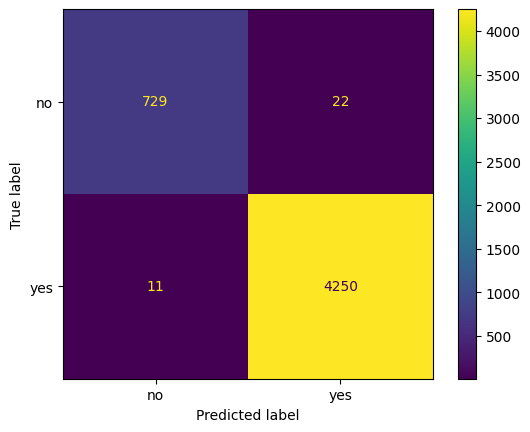

In [ ]:
accuracy, classification_rep, confusion_mat, roc_auc=evaluate_model(model_xgb_3, X_test_3, y_test_3)
performance_dict.append({'model':'xgb_base_3', 'accuracy':accuracy, 'classification_rep':classification_rep, 'confusion_mat':confusion_mat, 'roc_auc':roc_auc})

##Tune Hyper-parameters for XGBoost

In [ ]:
grid_search_3 = hyperparameter_tuning_xgb(X_train_3, y_train_3, X_test_3, y_test_3)

Starting Grid Search...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

--- Grid Search Complete ---
Best parameters found: {'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100}
Best ROC AUC score: 0.9989


## Evaluate tuned XGBoost

Accuracy: 0.9884277733439745
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96       751
           1       1.00      0.99      0.99      4261

    accuracy                           0.99      5012
   macro avg       0.97      0.98      0.98      5012
weighted avg       0.99      0.99      0.99      5012

Confusion Matrix:
 [[ 733   18]
 [  40 4221]]
ROC AUC Score: 0.9994184394991142


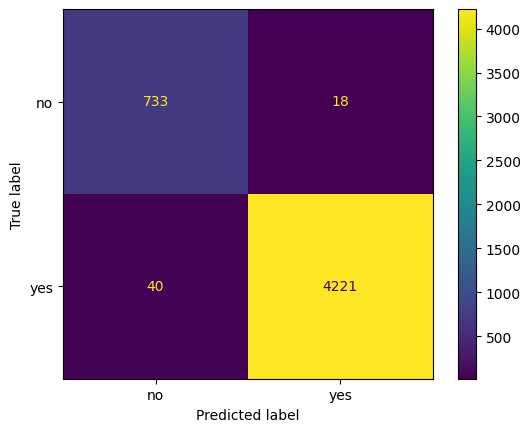

In [ ]:
accuracy, classification_rep, confusion_mat, roc_auc=evaluate_model(grid_search_3.best_estimator_, X_test_3, y_test_3)
performance_dict.append({'model':'xgb_best_3', 'accuracy':accuracy, 'classification_rep':classification_rep, 'confusion_mat':confusion_mat, 'roc_auc':roc_auc})

##Feature importances

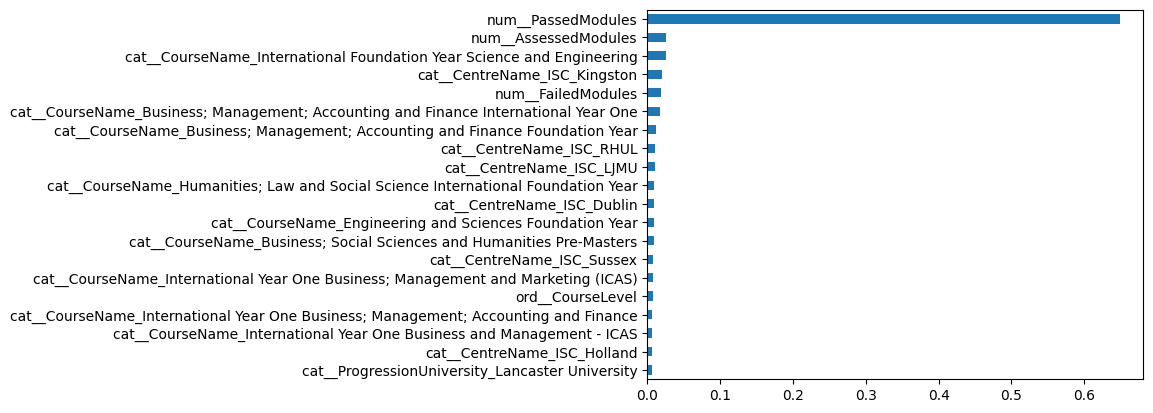

In [ ]:
get_feature_importances(grid_search_3.best_estimator_, preprocessor_3)

##Initialize and train base NN

In [ ]:
model_NN_3, history_model_3 = create_and_train_nn(X_train_3, y_train_3)

Using class weights: {0: np.float64(3.337828837828838), 1: np.float64(0.5880955174841587)}
Epoch 1/100
502/502 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8092 - auc: 0.8835 - loss: 0.5225 - val_accuracy: 0.9160 - val_auc: 0.9856 - val_loss: 0.2483
Epoch 2/100
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9198 - auc: 0.9839 - loss: 0.2182 - val_accuracy: 0.9444 - val_auc: 0.9949 - val_loss: 0.1619
Epoch 3/100
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9433 - auc: 0.9936 - loss: 0.1585 - val_accuracy: 0.9534 - val_auc: 0.9967 - val_loss: 0.1392
Epoch 4/100
502/502 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9585 - auc: 0.9962 - loss: 0.1289 - val_accuracy: 0.9693 - val_auc: 0.9971 - val_loss: 0.1170
Epoch 5/100
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9668 - auc: 0.9963 - loss: 0.1197 - val_accuracy: 0.9658 - val_auc: 0.9973 - val_loss: 0.1156
Epoch 6/100
502/502 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9761 - auc: 0.9976 - loss: 0.1028 - v

## Evaluate base NN

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.9782521947326417
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.99      0.93       751
           1       1.00      0.98      0.99      4261

    accuracy                           0.98      5012
   macro avg       0.94      0.98      0.96      5012
weighted avg       0.98      0.98      0.98      5012

Confusion Matrix:
 [[ 743    8]
 [ 101 4160]]
ROC AUC Score: 0.9988275040304548


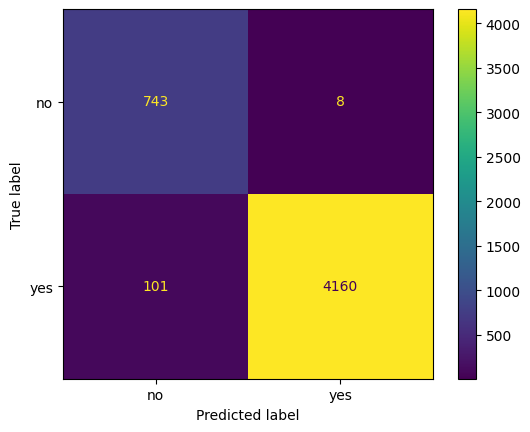

In [ ]:
accuracy, classification_rep, confusion_mat, roc_auc=evaluate_model(model_NN_3, X_test_3, y_test_3)
performance_dict.append({'model':'NN_base_3', 'accuracy':accuracy, 'classification_rep':classification_rep, 'confusion_mat':confusion_mat, 'roc_auc':roc_auc})

## Generate and Plot training & validation history NN

Training stopped at epoch 20
The best model weights were restored from epoch 10 with validation auc: 0.9983


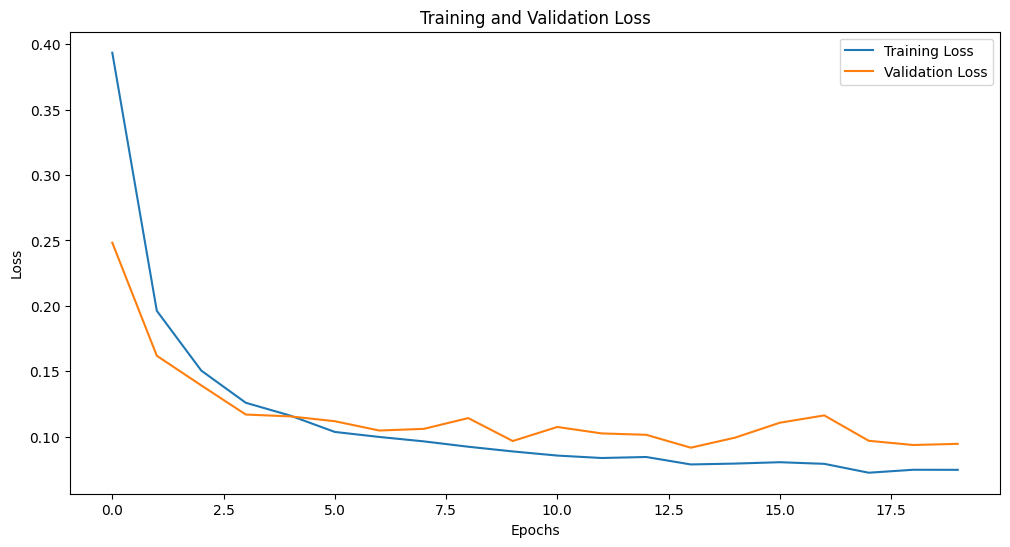

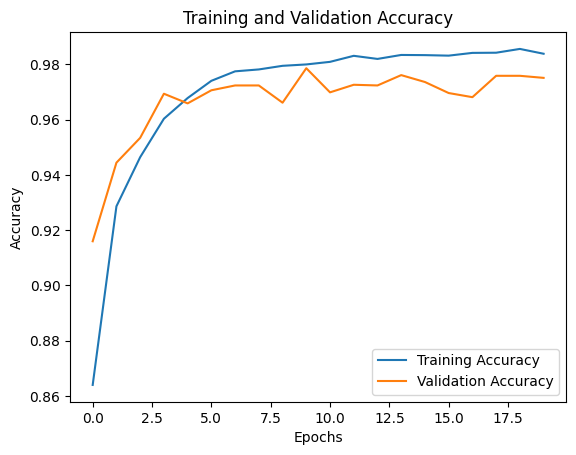

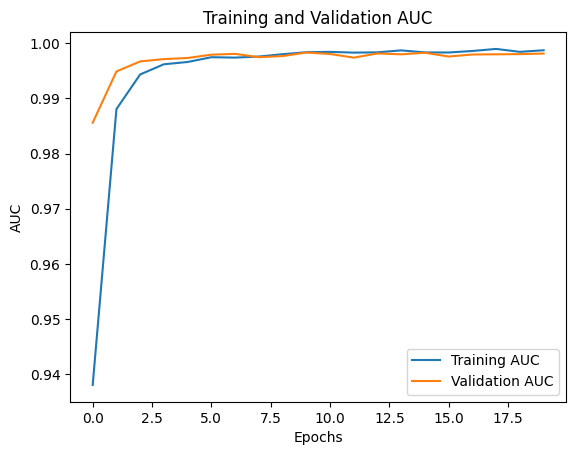

In [ ]:
generate_and_plot_loss_accuracy_history(history_model_3)

##Tune Hyper-parametes for NN (hyperband)

In [ ]:
best_model_3=get_best_hyperparameters_model_hyperband(X_train_3, y_train_3,project_name='StudentDropout_Stage3' )

Trial 90 Complete [00h 01m 53s]
val_auc: 0.9967958927154541

Best val_auc So Far: 0.9989203214645386
Total elapsed time: 00h 42m 11s

  The best hyperparameters are:
  - Depth: 3
  - Neuron Layers: [32, 64, 64]  # This will print something like [128, 64]
  - Optimizer: Adam
  


## Evaluate best NN

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy: 0.9770550678371908
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.99      0.93       751
           1       1.00      0.98      0.99      4261

    accuracy                           0.98      5012
   macro avg       0.94      0.98      0.96      5012
weighted avg       0.98      0.98      0.98      5012

Confusion Matrix:
 [[ 742    9]
 [ 106 4155]]
ROC AUC Score: 0.9989637535620971


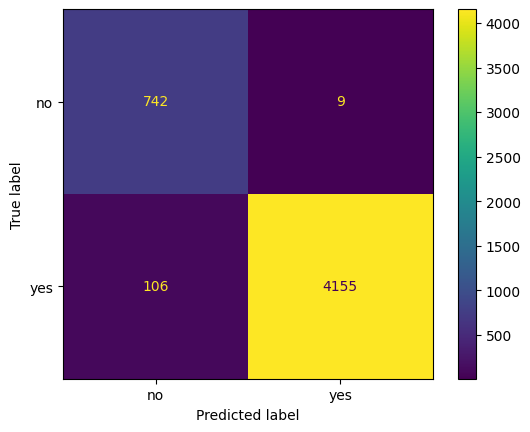

In [ ]:
accuracy, classification_rep, confusion_mat, roc_auc=evaluate_model(best_model_3, X_test_3, y_test_3)
performance_dict.append({'model':'NN_best_3', 'accuracy':accuracy, 'classification_rep':classification_rep, 'confusion_mat':confusion_mat, 'roc_auc':roc_auc})

##Print performances

In [ ]:
performance_df=pd.DataFrame(performance_dict)
performance_df

,model,accuracy,classification_rep,confusion_mat,roc_auc
0,xgb_base,0.891460,precision recall f1-score ...,"[[398, 353], [191, 4070]]",0.888701
1,xgb_base_balanced,0.853951,precision recall f1-score ...,"[[602, 149], [583, 3678]]",0.888822
2,xgb_best,0.856345,precision recall f1-score ...,"[[603, 148], [572, 3689]]",0.891751
3,NN_base,0.841381,precision recall f1-score ...,"[[605, 146], [649, 3612]]",0.889592
4,NN_best,0.864326,precision recall f1-score ...,"[[586, 165], [515, 3746]]",0.886599
5,xgb_base_2,0.876097,precision recall f1-score ...,"[[626, 125], [496, 3765]]",0.926370
6,xgb_best_2,0.874900,precision recall f1-score ...,"[[636, 115], [512, 3749]]",0.926698
7,NN_base_2,0.846568,precision recall f1-score ...,"[[645, 106], [663, 3598]]",0.913047
8,NN_best_2,0.866121,precision recall f1-score ...,"[[613, 138], [533, 3728]]",0.911027
9,xgb_base_3,0.993416,precision recall f1-score ...,"[[729, 22], [11, 4250]]",0.999460
